# Load the data 

In [4]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import fsolve


df_microled = pd.read_csv('id-v-microled.csv')
df_cadence = pd.read_csv('micro_led_tb_cadence.csv')
df_cadence_limited = pd.read_csv('micro_led_tb_cadence_limited_exponential.csv')
data_tft_saturation = pd.read_csv('P1G4_W50L5_Transfer_saturation.csv', skiprows=251)
data_tft_output = pd.read_csv('P1G4_W50L5_Output.csv', skiprows=256)


data_output_vds = [None]*9
data_output_id = [None]*9

for j in range(0, len(data_output_vds)):
    data_output_vds[j] = data_tft_output[' VD'].iloc[j*71:j*71+71].to_numpy()
    data_output_id[j] = data_tft_output[' ID'].iloc[j*71:j*71+71].to_numpy()

df_microled_working_region = df_microled[(df_microled['/I2/p1 Y'] > 10e-9) & (df_microled['/I2/p1 Y'] < 3e-6)]

# Problem 1 (MicroLED)

# Curve fit for obtain current parameters

In [5]:
ut_microled = 0.026

def obtainId_microled(v,Is, vt, n):
    return Is * (np.exp((v-vt)/(n*ut_microled)) - 1)

[Is_microled,vt_microled,n_microled], pcov = curve_fit(obtainId_microled, df_microled_working_region['/I2/p1 X'], df_microled_working_region['/I2/p1 Y'], p0=(1e-3,1,1))

print('Is_microled = ', Is_microled)
print('vt_microled = ', vt_microled)
print('n_microled = ', n_microled)

Is_microled =  1.8590268202397832e-18
vt_microled =  1.2200800720116642
n_microled =  1.3239995374285203


# Plot Cadence current characteristic Vs experimental results

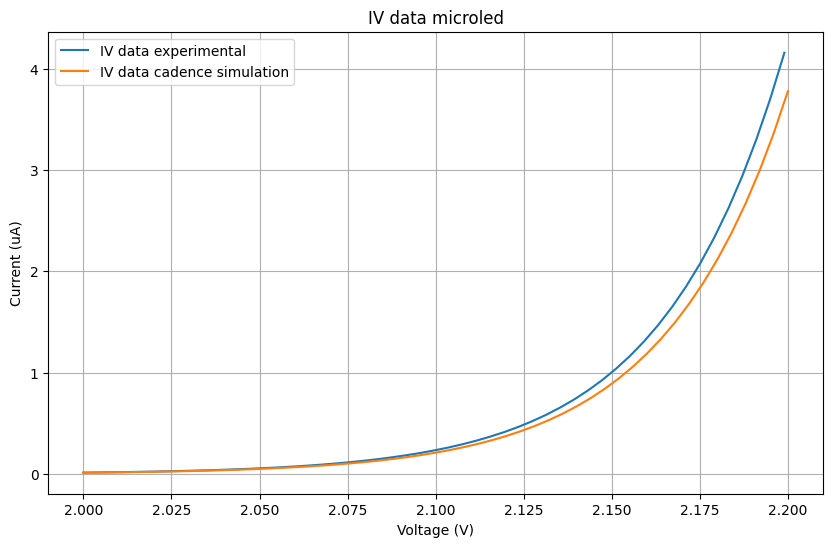

In [6]:
plt.figure(1, figsize=(10, 6))
plt.plot(df_microled['/I2/p1 X'], df_microled['/I2/p1 Y'] * 1e6, label='IV data experimental')
plt.plot(df_cadence['/I0/i X'], df_cadence['/I0/i Y'] * 1e6, label='IV data cadence simulation')   
plt.xlabel('Voltage (V)')
plt.ylabel('Current (uA)')
plt.legend(loc='best')
plt.title('IV data microled')
plt.grid()
plt.show()

Experimental Error

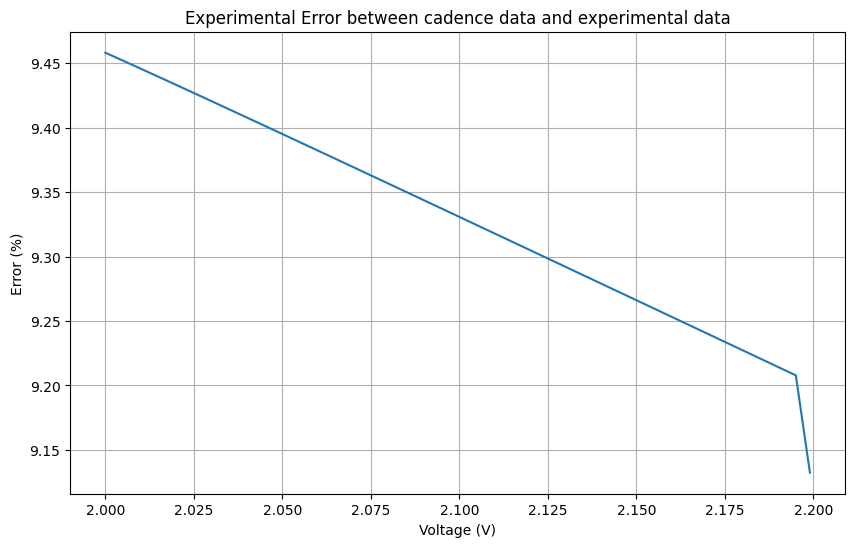

In [7]:
plt.figure(2, figsize=(10, 6))
plt.plot(df_microled['/I2/p1 X'], (abs(df_cadence['/I0/i Y'] * 1e6 - df_microled['/I2/p1 Y'] * 1e6) / (df_microled['/I2/p1 Y'] * 1e6)) * 100)
plt.xlabel('Voltage (V)')
plt.ylabel('Error (%)')
plt.title('Experimental Error between cadence data and experimental data')
plt.grid()
plt.show()

# Limited Exponential (obtain linear function)

In [8]:
df_microled_working_region_slope = df_microled_working_region[(df_microled_working_region['/I2/p1 Y'] > 2e-6) & (df_microled_working_region['/I2/p1 Y'] < 3e-6)]
print(df_microled_working_region_slope)

slope_microled, intercept_microled = np.polyfit(df_microled_working_region_slope['/I2/p1 X'], df_microled_working_region_slope['/I2/p1 Y'], 1)
print('slope = ', slope_microled)
print('intercept = ', intercept_microled)


    /I2/p1 X  /I2/p1 Y
44   2.17512  0.000002
45   2.17910  0.000002
46   2.18308  0.000003
47   2.18706  0.000003
slope =  7.220179524735389e-05
intercept =  -0.0001549837382267023


# Current Function

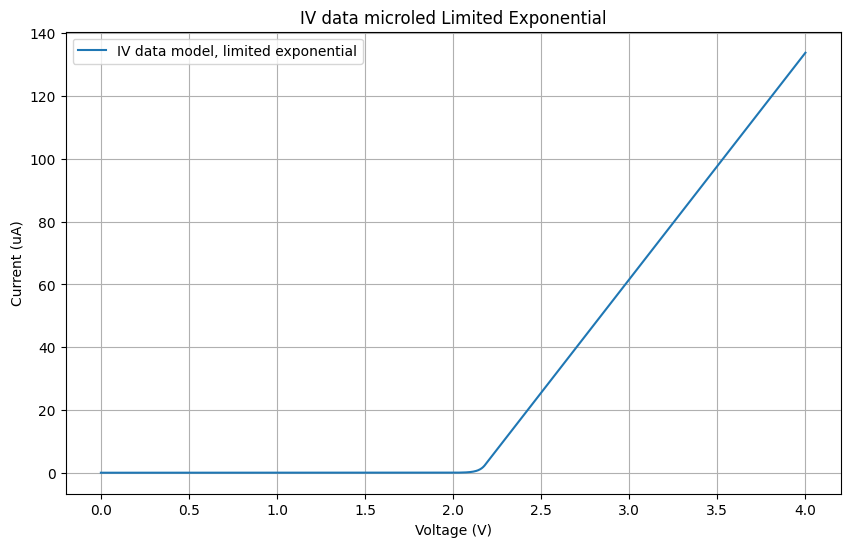

In [9]:
v_threshold_microled = 2.18706

def obtainId_microled_limited_exponential (v,Is, vt, n):
    return np.piecewise(v, [v < v_threshold_microled, v >= v_threshold_microled], [lambda v: Is * (np.exp((v-vt)/(n*ut_microled)) - 1), lambda v: slope_microled*v + intercept_microled])

v_microled = np.linspace(0, 4, 1000)

plt.figure(3, figsize=(10, 6))
plt.plot(v_microled, obtainId_microled_limited_exponential(v_microled, Is_microled, vt_microled, n_microled) * 1e6, label='IV data model, limited exponential')
plt.xlabel('Voltage (V)')
plt.ylabel('Current (uA)')
plt.legend(loc='best')
plt.title('IV data microled Limited Exponential')
plt.grid()
plt.show()

# Validation Limited Exponential Cadence

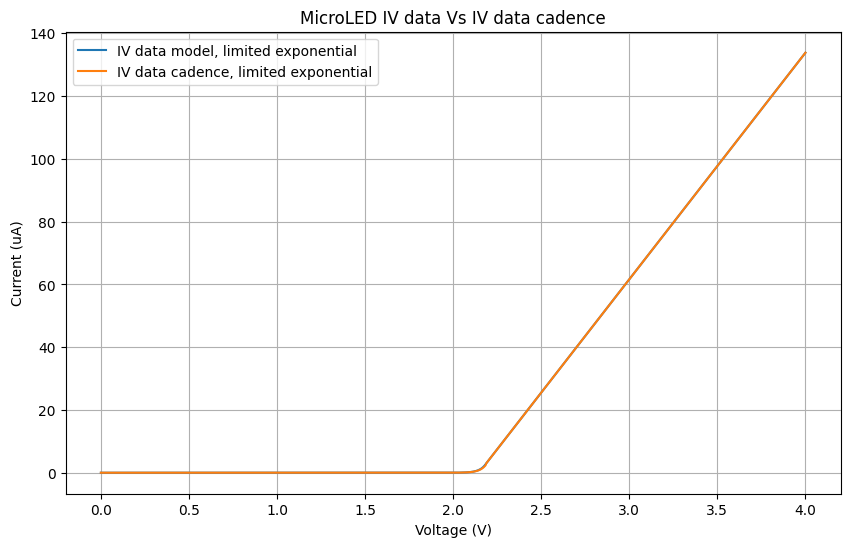

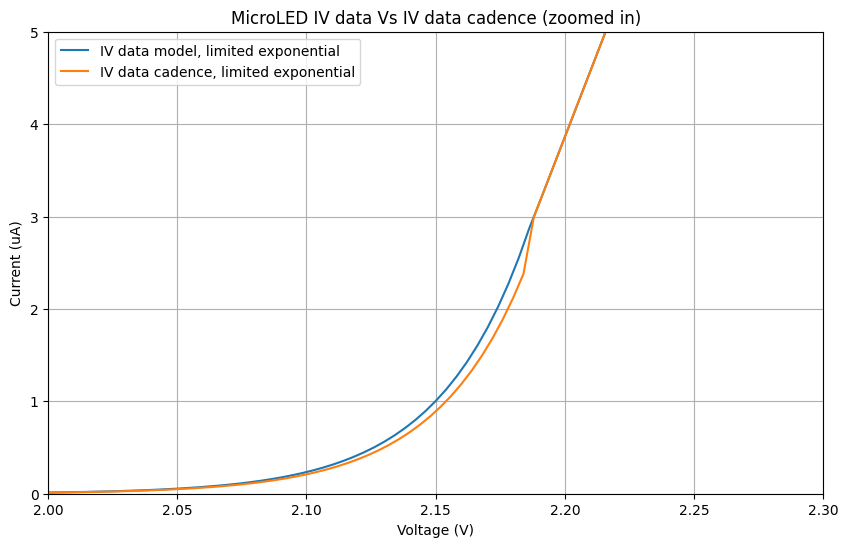

In [10]:
plt.figure(4, figsize=(10, 6))
plt.plot(v_microled, obtainId_microled_limited_exponential(v_microled, Is_microled, vt_microled, n_microled) * 1e6, label='IV data model, limited exponential')
plt.plot(df_cadence_limited['/I0/i X'], df_cadence_limited['/I0/i Y'] * 1e6, label='IV data cadence, limited exponential')   
plt.xlabel('Voltage (V)')
plt.ylabel('Current (uA)')
plt.legend(loc='best')
plt.title('MicroLED IV data Vs IV data cadence')
plt.grid()
plt.show() 

plt.figure(5, figsize=(10, 6))
plt.plot(v_microled, obtainId_microled_limited_exponential(v_microled, Is_microled, vt_microled, n_microled) * 1e6, label='IV data model, limited exponential')
plt.plot(df_cadence_limited['/I0/i X'], df_cadence_limited['/I0/i Y'] * 1e6, label='IV data cadence, limited exponential')   
plt.xlim(2,2.3)
plt.ylim(0,5)
plt.xlabel('Voltage (V)')
plt.ylabel('Current (uA)')
plt.legend(loc='best')
plt.title('MicroLED IV data Vs IV data cadence (zoomed in)')
plt.grid()
plt.show()

# Problem 2

### TFT constants 

In [ ]:
a1_tft = 0.0004246212659893926
a2_tft = -0.0038580151080255132
a3_tft = 0.013797120680445802
a4_tft = -0.01543728006841336
a5_tft = 0.013585461081624358

vin_tft = 3
#vin_tft = 2.9
vd_tft = 3
vs_desired = 2.18

vgs_tft = vin_tft - vs_desired
vds_tft = vd_tft - vs_desired

vt_tft = 0.1

### TFT 1 design

k_tft =  6.934255698092868e-06
m_tft =  2.0258549228343425


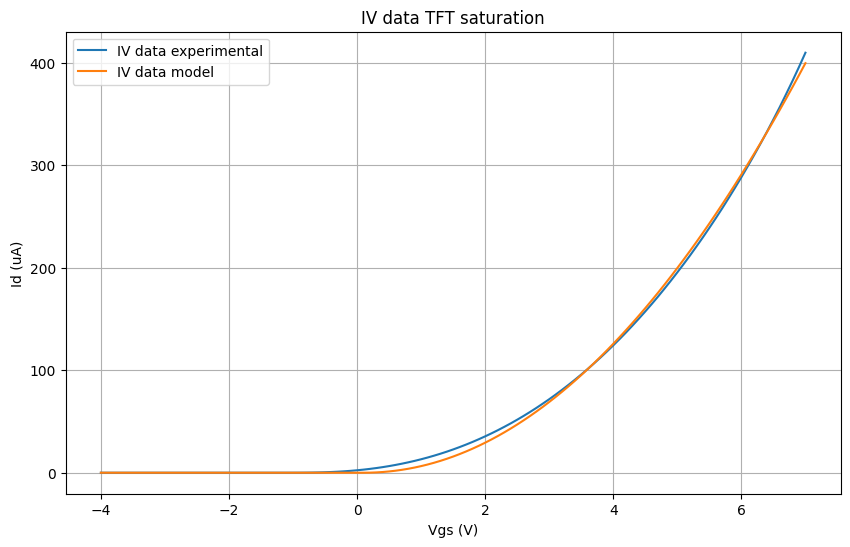

alpha_tft =  1.25


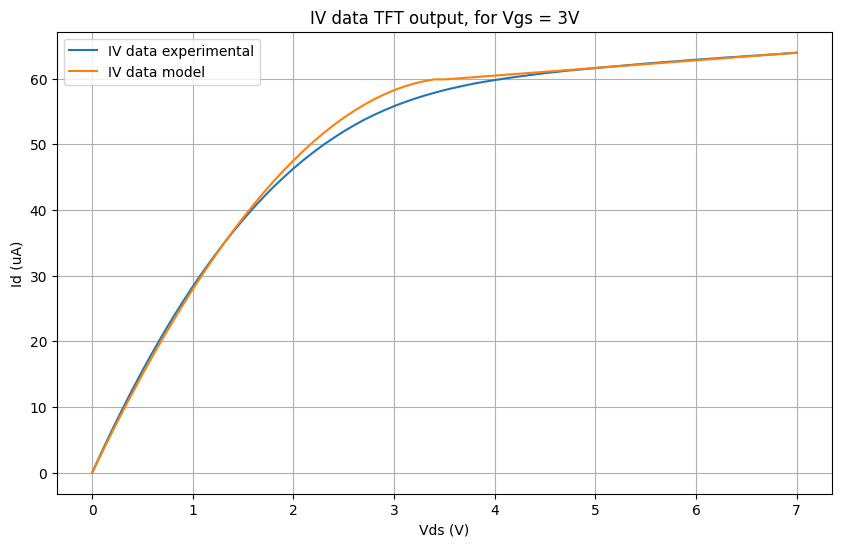

id_microled =  2.397043361127825e-06
(W/L) TFT =  [8.95197294]


In [ ]:
def obtainLambda_tft(vgs, a_1, a_2, a_3, a_4, a_5):
    return a_1*vgs**4 + a_2*vgs**3 + a_3*vgs**2 + a_4*vgs + a_5

lambda_vgs_3 = obtainLambda_tft(3, a1_tft, a2_tft, a3_tft, a4_tft, a5_tft)

def obtain_idsat_tft(vgs, k, m):
    return np.piecewise(vgs, [vgs <= vt_tft, vgs > vt_tft], [lambda vgs: 0, lambda vgs: k * ((vgs - vt_tft)**m) * (1 + (lambda_vgs_3 * 7))])

[k_tft, m_tft], pcov = curve_fit(obtain_idsat_tft, data_tft_saturation[' VG'].values, data_tft_saturation[' ID'].values)

print('k_tft = ', k_tft)
print('m_tft = ', m_tft)

plt.figure(6, figsize=(10, 6))
plt.plot(data_tft_saturation[' VG'], data_tft_saturation[' ID']*1e6, label='IV data experimental')
plt.plot(data_tft_saturation[' VG'], obtain_idsat_tft(data_tft_saturation[' VG'].values, k_tft, m_tft)*1e6, label='IV data model')
plt.xlabel('Vgs (V)')
plt.ylabel('Id (uA)')
plt.legend(loc='best')
plt.title('IV data TFT saturation')
plt.grid()
plt.show()

bx_tft = k_tft/10
w_l_tft_1 = k_tft/bx_tft

def obtain_id_tft(vds, alpha):
    return np.piecewise(vds, [vds < alpha*(vin_tft - vt_tft), vds >= alpha*(vin_tft - vt_tft)], [lambda vds: (2*bx_tft*w_l_tft_1/alpha) * ((vin_tft-vt_tft)**(m_tft-2)) * (vin_tft-vt_tft-(vds/(2*alpha))) * vds * (1+vds*obtainLambda_tft(3,a1_tft,a2_tft,a3_tft,a4_tft,a5_tft)), lambda vds: (bx_tft*w_l_tft_1) * ((vin_tft-vt_tft)**m_tft) * (1+vds*obtainLambda_tft(vin_tft,a1_tft,a2_tft,a3_tft,a4_tft,a5_tft))])
 
[alpha_tft], pcov = curve_fit(obtain_id_tft, data_output_vds[4], data_output_id[4], bounds=(1,1.5))

print('alpha_tft = ', alpha_tft)

plt.figure(7, figsize=(10, 6))
plt.plot(data_output_vds[4], data_output_id[4]*1e6, label='IV data experimental')
plt.plot(data_output_vds[4], obtain_id_tft(data_output_vds[4], alpha_tft)*1e6, label='IV data model')
plt.xlabel('Vds (V)')
plt.ylabel('Id (uA)')
plt.legend(loc='best')
plt.title('IV data TFT output, for Vgs = 3V')
plt.grid()
plt.show()


id_microled = obtainId_microled_limited_exponential(vs_desired, Is_microled, vt_microled, n_microled)
print('id_microled = ', id_microled)

id_tft = id_microled 

def obtain_id_tft_2(vds, alpha, w_l):
    return np.piecewise(vds, [vds < alpha*(vgs_tft - vt_tft), vds >= alpha*(vgs_tft - vt_tft)], [lambda vds: (2*bx_tft*w_l/alpha) * ((vgs_tft-vt_tft)**(m_tft-2)) * (vgs_tft-vt_tft-(vds/(2*alpha))) * vds * (1+vds*obtainLambda_tft(3,a1_tft,a2_tft,a3_tft,a4_tft,a5_tft)), lambda vds: (bx_tft*w_l) * ((vgs_tft-vt_tft)**m_tft) * (1+vds*obtainLambda_tft(vin_tft,a1_tft,a2_tft,a3_tft,a4_tft,a5_tft))])


def get_w_l_tft (w_l):
    return id_tft - obtain_id_tft_2(vds_tft, alpha_tft, w_l)

w_l_tft_2 = fsolve(get_w_l_tft, 0)

print('(W/L) TFT = ', w_l_tft_2)